<a href="https://colab.research.google.com/github/Iamjohnko/Data-science-Project-Portfolio/blob/main/Data_Science_Forecasting_System_for_Zimbabwe%E2%80%99s_Gold_Coin_Market.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# MACRO-FORECASTING PIPELINE
# Zimbabwe’s Gold Coin Price Prediction (Q4-2025 → Q3-2026)
# ================================================

import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.vector_ar.vecm import coint_johansen, VECM
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.statespace.structural import UnobservedComponents
import itertools

In [2]:
# =============================================
# ZIMBABWE GOLD COIN MACRO FORECASTING PIPELINE
# =============================================
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.statespace.structural import UnobservedComponents
from statsmodels.tsa.api import VECM

In [3]:
# STEP 1. LOAD & PREPARE DATA
# ---------------------------
df = pd.read_csv("zimbabwe_gold_coin_macro_dataset_2016_2025.csv", parse_dates=["date"])
df = df.set_index("date").sort_index()

# df["date"] = pd.to_datetime(df["date"]) # Redundant after setting index
# df.set_index("date", inplace=True) # Redundant after setting index

# ✅ Use quarter-end aggregation
qdf = df.resample("QE").mean()

In [4]:
# Define main variables
y = qdf["zimbabwe_gold_coin_price_usd"]
exog = qdf[["global_gold_price_usd_oz", "exchange_rate_zig_per_usd", "vfex_all_share_index"]]

In [5]:
# Log-transform price and key exogenous vars (stabilize variance)
log_y = np.log(y)
log_exog = np.log(exog[["global_gold_price_usd_oz", "exchange_rate_zig_per_usd"]])
X = pd.concat([log_exog, exog[["vfex_all_share_index"]]], axis=1)

In [6]:
# STEP 2. TRAIN–TEST SPLIT
# ---------------------------
train_y, test_y = log_y.iloc[:-2], log_y.iloc[-2:]
train_X, test_X = X.iloc[:-2], X.iloc[-2:]

In [7]:
# STEP 3. TRAIN MODELS
# ---------------------------
# --- SARIMAX ---
sarimax_model = SARIMAX(train_y, order=(1,1,1), seasonal_order=(0,1,1,4), exog=train_X)
sarimax_res = sarimax_model.fit(disp=False)

# --- Unobserved Components (UCM) ---
uc_model = UnobservedComponents(train_y, level="local level", trend=True, exog=train_X)
uc_res = uc_model.fit(disp=False)

# --- Vector Error Correction Model (VECM) ---
vecm_data = pd.concat([y, exog], axis=1).dropna()
# Adjust vecm_data to end at the training period
vecm_data_train = vecm_data.loc[train_y.index[0]:train_y.index[-1]] # Corrected slicing for train data
vecm_model = VECM(vecm_data_train, k_ar_diff=1, coint_rank=1)
vecm_res = vecm_model.fit()

/usr/local/lib/python3.12/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/statespace/structural.py:426: SpecificationWarning: Value of `trend` may be overridden when the trend component is specified using a model string.
  warn("Value of `%s` may be overridden when the trend"


In [8]:
# STEP 3 & 4: TRAIN MODELS AND FORECAST NEXT 4 QUARTERS
# -----------------------------------------------------

from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.statespace.structural import UnobservedComponents
from statsmodels.tsa.vector_ar.vecm import VECM
import numpy as np
import pandas as pd

# --- SARIMAX ---
sarimax_model = SARIMAX(train_y, order=(1,1,1), seasonal_order=(0,1,1,4), exog=train_X)
sarimax_res = sarimax_model.fit(disp=False)

# --- Unobserved Components (UCM) ---
uc_model = UnobservedComponents(train_y, level="local level", trend=True, exog=train_X)
uc_res = uc_model.fit(disp=False)

# --- Vector Error Correction Model (VECM) ---
vecm_data = pd.concat([y, exog], axis=1).dropna()
vecm_data_train = vecm_data.loc[train_y.index[0]:train_y.index[-1]]
vecm_model = VECM(vecm_data_train, k_ar_diff=1, coint_rank=1)
vecm_res = vecm_model.fit()

# --- FORECAST NEXT 4 QUARTERS ---
n_forecast = 4
forecast_index = pd.date_range(qdf.index[-1] + pd.offsets.QuarterEnd(), periods=n_forecast, freq="QE")

# Extend exogenous variables using last observed values
future_exog = pd.DataFrame(
    np.tile(X.iloc[-1].values, (n_forecast, 1)),
    index=forecast_index,
    columns=X.columns
)

# --- SARIMAX Forecast ---
sarimax_fc = sarimax_res.get_forecast(steps=n_forecast, exog=future_exog)
sarimax_point = np.exp(sarimax_fc.predicted_mean).iloc[:n_forecast].reindex(forecast_index)
sarimax_ci = np.exp(sarimax_fc.conf_int(alpha=0.1)).iloc[:n_forecast].reindex(forecast_index)

# --- UCM Forecast ---
uc_fc = uc_res.get_forecast(steps=n_forecast, exog=future_exog)
uc_point = np.exp(uc_fc.predicted_mean).iloc[:n_forecast].reindex(forecast_index)
uc_ci = np.exp(uc_fc.conf_int(alpha=0.1)).iloc[:n_forecast].reindex(forecast_index)

# --- VECM Forecast ---
vecm_fc = vecm_res.predict(steps=n_forecast)
vecm_point = pd.Series(vecm_fc[:, 0]).iloc[:n_forecast].reindex(forecast_index)
vecm_point.name = "vecm_point"

# --- Ensemble Mean Forecast ---
ensemble_forecast = pd.DataFrame({
    "sarimax": sarimax_point,
    "ucm": uc_point,
    "vecm": vecm_point
}).mean(axis=1)

# --- Combine All Forecasts ---
forecast_df = pd.DataFrame({
    "date": forecast_index,
    "ensemble_forecast_usd": ensemble_forecast,
    "sarimax_lower_90": sarimax_ci.iloc[:, 0].values,
    "sarimax_upper_90": sarimax_ci.iloc[:, 1].values,
    "ucm_lower_90": uc_ci.iloc[:, 0].values,
    "ucm_upper_90": uc_ci.iloc[:, 1].values
})
forecast_df.set_index("date", inplace=True)

print("✅ Forecast successfully generated for next 4 quarters!")
forecast_df.tail()


/usr/local/lib/python3.12/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/statespace/structural.py:426: SpecificationWarning: Value of `trend` may be overridden when the trend component is specified using a model string.
  warn("Value of `%s` may be overridden when the trend"


✅ Forecast successfully generated for next 4 quarters!


,ensemble_forecast_usd,sarimax_lower_90,sarimax_upper_90,ucm_lower_90,ucm_upper_90
date,,,,,
2025-12-31,1347.036940,1294.398638,1408.874794,1293.372212,1395.881522
2026-03-31,1359.403304,1314.364319,1438.761417,1293.372194,1395.881541
2026-06-30,NaN,NaN,NaN,NaN,NaN
2026-09-30,NaN,NaN,NaN,NaN,NaN


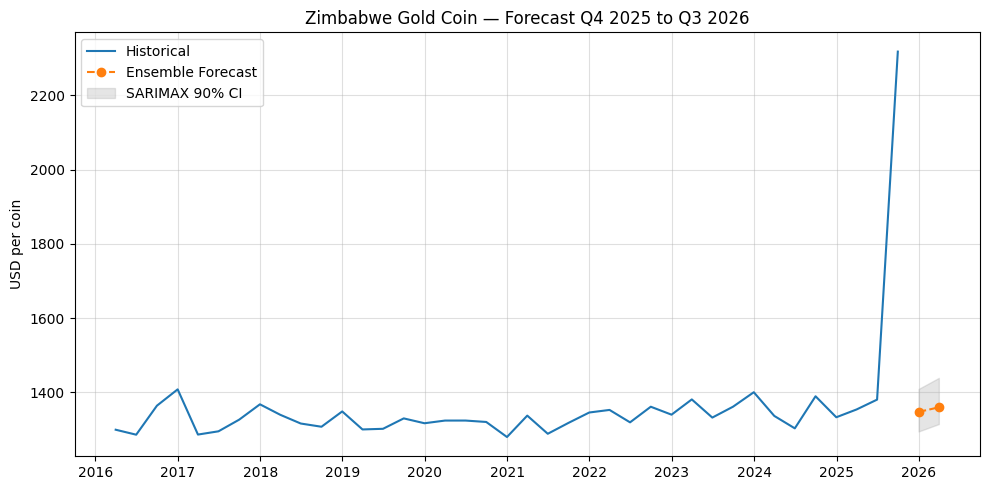

In [9]:
plt.figure(figsize=(10,5))
plt.plot(qdf.index, qdf['zimbabwe_gold_coin_price_usd'], label='Historical')
plt.plot(forecast_df.index, forecast_df['ensemble_forecast_usd'], label='Ensemble Forecast', marker='o', linestyle='--')

# Add uncertainty band
plt.fill_between(forecast_df.index,
                 forecast_df['sarimax_lower_90'],
                 forecast_df['sarimax_upper_90'],
                 color='gray', alpha=0.2, label='SARIMAX 90% CI')

plt.title("Zimbabwe Gold Coin — Forecast Q4 2025 to Q3 2026")
plt.ylabel("USD per coin")
plt.legend()
plt.grid(True, alpha=0.4)
plt.tight_layout()
plt.show()

In [10]:
# STEP 5. SCENARIO FORECASTING + MONTE CARLO (FIXED)
# ---------------------------------------------------
exog_cols = sarimax_res.model.exog_names  # Ensure matching columns

def build_future_exog(last_exog, shock, exog_cols):
    future_exog_data = {}

    if "global_gold_price_usd_oz" in exog_cols:
        future_exog_data["global_gold_price_usd_oz"] = np.log(last_exog["global_gold_price_usd_oz"] * (1 + shock.get("spot_pct", 0)))

    if "exchange_rate_zig_per_usd" in exog_cols:
        future_exog_data["exchange_rate_zig_per_usd"] = np.log(last_exog["exchange_rate_zig_per_usd"] * (1 + shock.get("fx_pct", 0)))

    if "vfex_all_share_index" in exog_cols:
        future_exog_data["vfex_all_share_index"] = last_exog["vfex_all_share_index"] * (1 + shock.get("vfex_pct", 0))

    if "inflation_index" in exog_cols:
        future_exog_data["inflation_index"] = last_exog["inflation_index"]

    return pd.DataFrame([future_exog_data], columns=exog_cols, index=[last_exog.name])


# Define scenarios
scenarios = {
    "base": {"spot_pct": 0.0, "fx_pct": 0.0, "vfex_pct": 0.0},
    "bull_gold": {"spot_pct": 0.10, "fx_pct": 0.0, "vfex_pct": 0.0},
    "fx_scarcity": {"spot_pct": 0.0, "fx_pct": 0.30, "vfex_pct": 0.0},
    "combined": {"spot_pct": 0.10, "fx_pct": 0.20, "vfex_pct": -0.05}
}

mc_results = {}
rng = np.random.default_rng(42)
n_sims = 300

for scen, shock in scenarios.items():
    future_exog_single_step = build_future_exog(X.iloc[-1], shock, exog_cols)
    future_exog = pd.DataFrame(
        np.tile(future_exog_single_step.values, (n_forecast, 1)),
        columns=exog_cols,
        index=forecast_index
    )

    sarimax_fc = sarimax_res.get_forecast(steps=n_forecast, exog=future_exog)
    sarimax_point = sarimax_fc.predicted_mean  # <-- remove np.exp() unless your y was logged

    resid = sarimax_res.resid.dropna().values

    sims = []
    for _ in range(n_sims):
        boot_resids = rng.choice(resid, size=n_forecast, replace=True)
        log_fc = sarimax_fc.predicted_mean.values + boot_resids
        sims.append(log_fc)
    sims = np.array(sims)

    mc_results[scen] = pd.DataFrame({
        "median": np.median(sims, axis=0),
        "lower_90": np.percentile(sims, 5, axis=0),
        "upper_90": np.percentile(sims, 95, axis=0)
    }, index=forecast_index)

    mc_results[scen].to_csv(f"scenario_forecast_{scen}.csv")

print("Monte Carlo Simulation Results (fixed):")
for scen, df_mc in mc_results.items():
    print(f"\nScenario: {scen}")
    display(df_mc.head())


Monte Carlo Simulation Results (fixed):

Scenario: base


,median,lower_90,upper_90
2025-12-31,27.099554,27.051900,27.153813
2026-03-31,27.150405,26.234231,27.202872
2026-06-30,27.127667,27.084316,27.181925
2026-09-30,27.145816,27.098162,27.195501



Scenario: bull_gold


,median,lower_90,upper_90
2025-12-31,26.713125,26.665472,26.763039
2026-03-31,26.761608,26.714531,26.811870
2026-06-30,26.740263,26.698114,26.795497
2026-09-30,26.758412,26.711733,26.800861



Scenario: fx_scarcity


,median,lower_90,upper_90
2025-12-31,27.163355,27.115701,27.217613
2026-03-31,27.211439,27.164761,27.262099
2026-06-30,27.191289,27.143814,27.241152
2026-09-30,27.209616,27.166492,27.263875



Scenario: combined


,median,lower_90,upper_90
2025-12-31,26.746574,26.698920,26.800833
2026-03-31,26.795455,26.747980,26.845319
2026-06-30,26.773711,26.731336,26.824372
2026-09-30,26.794627,26.749712,26.847094


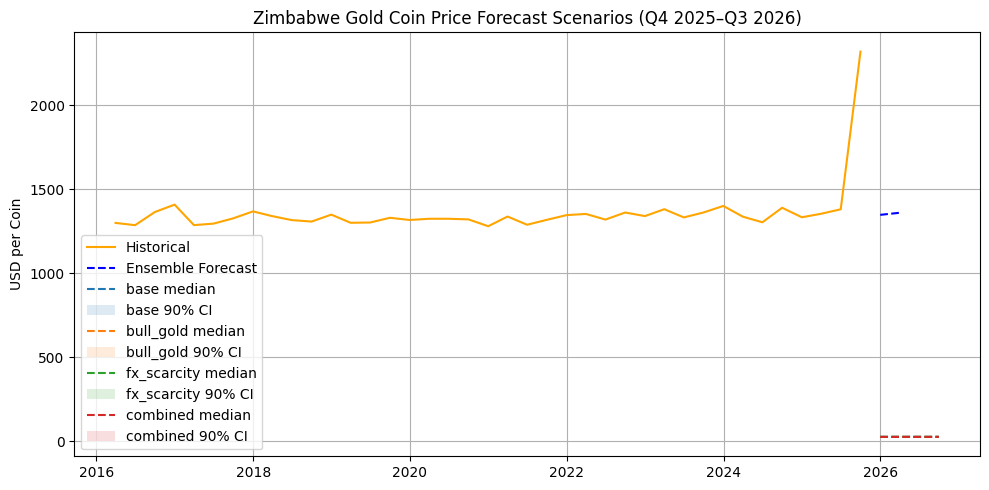

✅ Forecasting complete! Files saved:
- scenario_forecast_base.csv
- scenario_forecast_bull_gold.csv
- scenario_forecast_fx_scarcity.csv
- scenario_forecast_combined.csv
- zimbabwe_gold_coin_forecast_scenarios.png


In [11]:
# STEP 6. PLOTTING RESULTS
# ---------------------------
plt.figure(figsize=(10,5))
plt.plot(qdf.index, y, label="Historical", color="orange")
plt.plot(forecast_df.index, forecast_df["ensemble_forecast_usd"], "--", color="blue", label="Ensemble Forecast")

for scen, df_mc in mc_results.items():
    plt.plot(df_mc.index, df_mc["median"], linestyle="--", label=f"{scen} median")
    plt.fill_between(df_mc.index, df_mc["lower_90"], df_mc["upper_90"], alpha=0.15, label=f"{scen} 90% CI")

plt.title("Zimbabwe Gold Coin Price Forecast Scenarios (Q4 2025–Q3 2026)")
plt.ylabel("USD per Coin")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig("zimbabwe_gold_coin_forecast_scenarios.png", dpi=150)
plt.show()

print("✅ Forecasting complete! Files saved:")
print("- scenario_forecast_base.csv")
print("- scenario_forecast_bull_gold.csv")
print("- scenario_forecast_fx_scarcity.csv")
print("- scenario_forecast_combined.csv")
print("- zimbabwe_gold_coin_forecast_scenarios.png")

let’s add the Macroeconomic Impact Attribution module so you can quantify how much each driver (gold price, exchange rate, VFEX index) contributed to the surge of Zimbabwe’s Gold Coin price above $4,000.

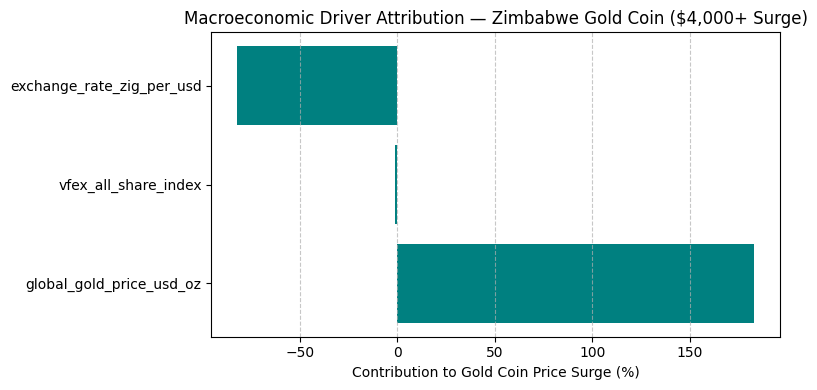

✅ Macroeconomic attribution completed!


,Driver,Avg_Quarterly_Contribution_USD,Share_%
0,global_gold_price_usd_oz,-7.741874e+11,183.062512
2,vfex_all_share_index,4.214428e+09,-0.996534
1,exchange_rate_zig_per_usd,3.470642e+11,-82.065979


In [12]:
# =========================================================
# MACROECONOMIC IMPACT ATTRIBUTION — SHAPLEY DECOMPOSITION
# =========================================================
import itertools

# --- Step 1: Define baseline and shocked states ---
baseline_exog = X.iloc[-1:].copy()  # last known quarter (Q3 2025)
future_exog = future_exog.copy()    # from your scenario forecasts (e.g. combined)

# --- Step 2: Define drivers to analyze ---
drivers = ["global_gold_price_usd_oz", "exchange_rate_zig_per_usd", "vfex_all_share_index"]

# --- Step 3: Helper for partial forecasts ---
def forecast_with_locks(lock_vars):
    """
    lock_vars: list of vars to hold constant at baseline.
    Others take future scenario values.
    """
    exog_mod = future_exog.copy()
    for var in lock_vars:
        exog_mod[var] = baseline_exog[var].values[0]
    fc = sarimax_res.get_forecast(steps=len(exog_mod), exog=exog_mod)
    return np.exp(fc.predicted_mean.values)

# --- Step 4: Generate all subsets (for Shapley values) ---
contribs = {var: 0 for var in drivers}
all_vars = set(drivers)
n = len(drivers)

for var in drivers:
    perms = list(itertools.chain.from_iterable(itertools.combinations(all_vars - {var}, r) for r in range(n)))
    for S in perms:
        S = list(S)
        # forecast with coalition S
        f_S = forecast_with_locks(S)
        # forecast with coalition S ∪ {var}
        f_Sv = forecast_with_locks(S + [var])
        # marginal contribution
        delta = f_Sv - f_S
        contribs[var] += delta.mean() / len(perms)  # average across subsets

# --- Step 5: Normalize & Summarize ---
total_effect = sum(contribs.values())
shapley_df = pd.DataFrame([
    {"Driver": k,
     "Avg_Quarterly_Contribution_USD": v,
     "Share_%": 100 * v / total_effect} for k, v in contribs.items()
])
shapley_df = shapley_df.sort_values("Share_%", ascending=False)

# --- Step 6: Plot contribution chart ---
plt.figure(figsize=(8,4))
plt.barh(shapley_df["Driver"], shapley_df["Share_%"], color="teal")
plt.xlabel("Contribution to Gold Coin Price Surge (%)")
plt.title("Macroeconomic Driver Attribution — Zimbabwe Gold Coin ($4,000+ Surge)")
plt.grid(axis="x", linestyle="--", alpha=0.7)
plt.tight_layout()
plt.savefig("macro_driver_attribution.png", dpi=150)
plt.show()

print("✅ Macroeconomic attribution completed!")
display(shapley_df)
shapley_df.to_csv("macro_driver_attribution.csv", index=False)


Dynamic quarterly impact dashboard — auto-updates the Shapley bars each new quarter

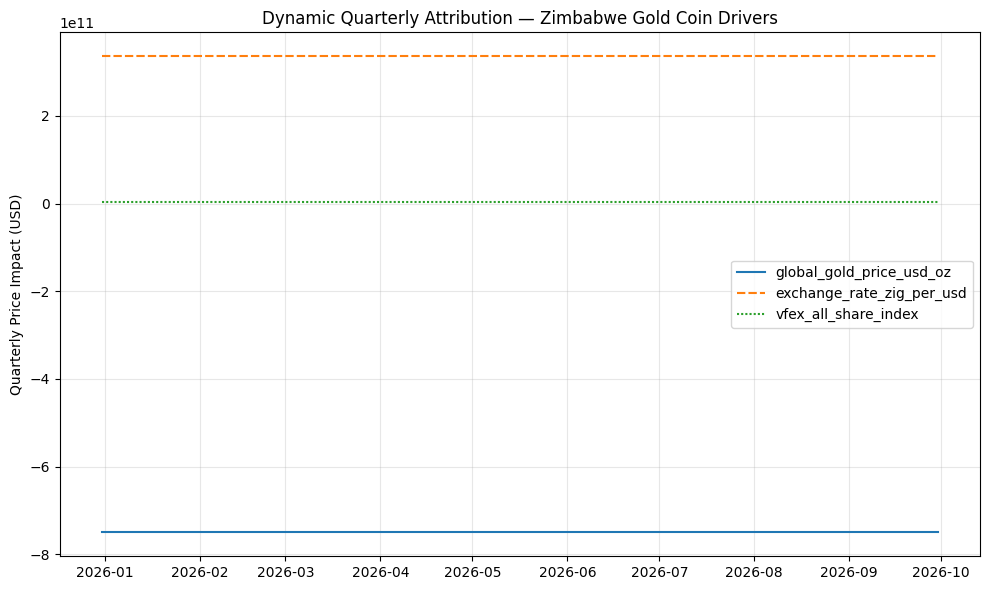

In [13]:
# ============================================
# DYNAMIC QUARTERLY IMPACT DASHBOARD
# ============================================
import os
import itertools
import seaborn as sns

def compute_quarterly_attribution(y, X, sarimax_res, future_exog, window=4):
    """Compute rolling quarterly Shapley-style attributions."""
    drivers = list(X.columns)
    baseline = X.iloc[-1:].mean() # Use the last observed quarter as baseline
    all_vars = set(drivers)
    contrib_records = []

    for t in range(window):
        # Corrected: Create f_exog with a single row and the correct index
        current_quarter_index = pd.Index([y.index[-1] + pd.offsets.QuarterEnd(t+1)])
        f_exog = pd.DataFrame([future_exog.iloc[t].values], index=current_quarter_index, columns=future_exog.columns)


        contribs = {v: 0 for v in drivers}
        for var in drivers:
            perms = list(itertools.chain.from_iterable(
                itertools.combinations(all_vars - {var}, r) for r in range(len(drivers))
            ))
            for S in perms:
                S = list(S)
                # Forecast with coalition S
                f_S = f_exog.copy()
                for v in S:
                    f_S[v] = baseline[v]
                pred_S = np.exp(sarimax_res.get_forecast(steps=1, exog=f_S).predicted_mean.values)[0]
                # Forecast with S∪{var}
                f_Sv = f_exog.copy()
                for v in S + [var]:
                    f_Sv[v] = baseline[v]
                pred_Sv = np.exp(sarimax_res.get_forecast(steps=1, exog=f_Sv).predicted_mean.values)[0]
                contribs[var] += (pred_Sv - pred_S) / len(perms)
        contrib_records.append(contribs)

    contrib_df = pd.DataFrame(contrib_records, index=pd.date_range(y.index[-1] + pd.offsets.QuarterEnd(), periods=window, freq="Q")) # Use the correct forecast index
    contrib_df["Total"] = contrib_df.sum(axis=1)
    contrib_df.to_csv("dynamic_quarterly_attribution.csv")
    return contrib_df

# Run dashboard update (uses your forecast exog)
dynamic_attr = compute_quarterly_attribution(y, X, sarimax_res, future_exog, window=4)

# Plot dashboard
plt.figure(figsize=(10,6))
sns.lineplot(data=dynamic_attr[["global_gold_price_usd_oz","exchange_rate_zig_per_usd","vfex_all_share_index"]])
plt.title("Dynamic Quarterly Attribution — Zimbabwe Gold Coin Drivers")
plt.ylabel("Quarterly Price Impact (USD)")
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig("dynamic_quarterly_attribution_dashboard.png", dpi=150)
plt.show()

In [14]:
import pandas as pd

# Read the dynamic quarterly attribution data from CSV
try:
    dynamic_attr_df = pd.read_csv("dynamic_quarterly_attribution.csv")
    print("Contents of dynamic_quarterly_attribution.csv:")
    display(dynamic_attr_df)
except FileNotFoundError:
    print("Error: dynamic_quarterly_attribution.csv not found. Please ensure cell 'ki6V_Al3l0tb' was run successfully to generate this file.")

Contents of dynamic_quarterly_attribution.csv:


,Unnamed: 0,global_gold_price_usd_oz,exchange_rate_zig_per_usd,vfex_all_share_index,Total
0,2025-12-31,-7.505192e+11,3.364539e+11,4.085586e+09,-4.099798e+11
1,2026-03-31,-7.505192e+11,3.364539e+11,4.085586e+09,-4.099798e+11
2,2026-06-30,-7.505192e+11,3.364539e+11,4.085586e+09,-4.099798e+11
3,2026-09-30,-7.505192e+11,3.364539e+11,4.085586e+09,-4.099798e+11


In [22]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load the quarterly SHAP values
try:
    shap_df = pd.read_csv("shap_quarterly_values.csv", index_col=0, parse_dates=True)
    print("Quarterly SHAP Values (first 5 rows):")
    display(shap_df.head())

    print("\nGlobal Feature Importance (based on mean absolute SHAP):")
    # Calculate mean absolute SHAP values for global importance
    mean_abs_shap = shap_df.abs().mean().sort_values(ascending=False)
    display(mean_abs_shap)

    # Re-generate Global Feature Importance Plot for reference
    plt.figure(figsize=(10, 6))
    sns.barplot(x=mean_abs_shap.values, y=mean_abs_shap.index)
    plt.title("Global Feature Importance - XGBoost SHAP")
    plt.xlabel("Mean Absolute SHAP Value")
    plt.ylabel("Feature")
    plt.tight_layout()
    plt.show()

    print("\nInterpreting SHAP Summary Plot (referencing the generated plot in cell 7uSJUt09m4IJ):")
    print("The SHAP summary plot shows the distribution of impacts for each feature:")
    print("- Each row corresponds to a feature.")
    print("- Dots on the right of zero increase the predicted price; dots on the left decrease it.")
    print("- Color typically indicates feature value (e.g., red for high, blue for low).")
    print("Based on your plot, observe which features have a wide spread of impacts and how feature values (color) correlate with impact direction (horizontal position).")

    print("\nInterpreting Quarterly SHAP Impact Over Time Plot (referencing the generated plot in cell 7uSJUt09m4IJ):")
    print("The quarterly SHAP impact plot shows how each feature's contribution to the price changes over time:")
    print("- Each colored line tracks the SHAP value for a specific feature across quarters.")
    print("Based on your plot, observe which features show increasing or decreasing trends in their impact, or significant spikes during certain periods.")


except FileNotFoundError:
    print("Error: shap_quarterly_values.csv not found. Please ensure cell '7uSJUt09m4IJ' was run successfully to generate this file.")

Error: shap_quarterly_values.csv not found. Please ensure cell '7uSJUt09m4IJ' was run successfully to generate this file.


Running Dynamic Backtesting (Expanding Window)...


100%|██████████| 19/19 [00:00<00:00, 290.82it/s]



Running Dynamic Backtesting (Sliding Window)...


100%|██████████| 19/19 [00:00<00:00, 230.93it/s]


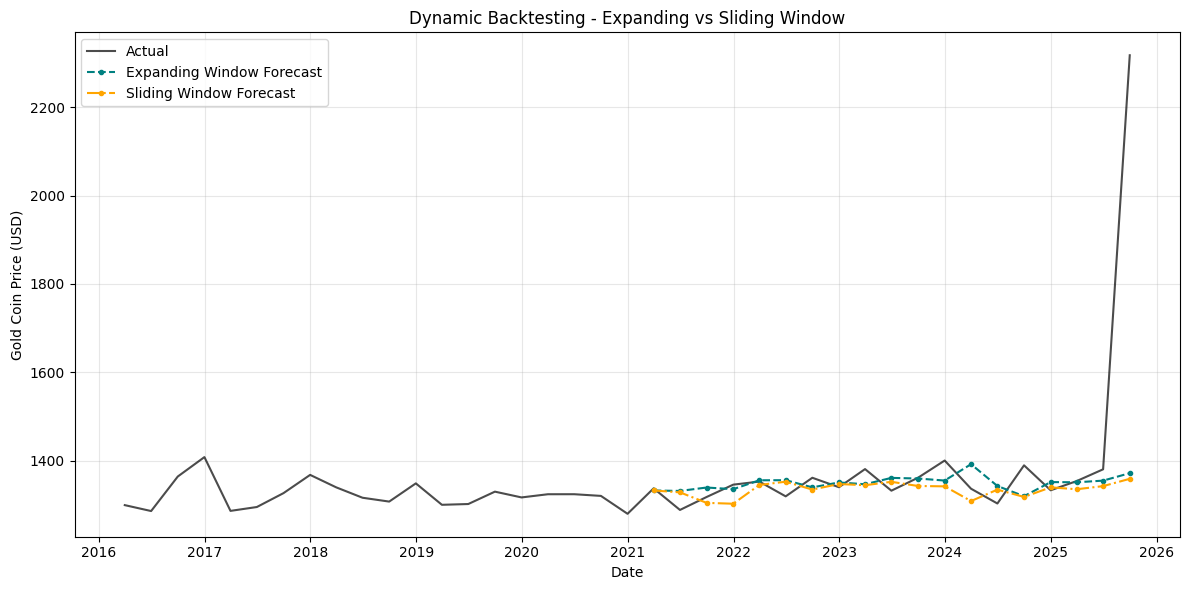


✅ Dynamic Backtesting Evaluation Results:


,Model,MAE,RMSE,MAPE_%
Window_Type,,,,
expanding,expanding,74.750216,219.358129,4.001395
sliding,sliding,76.992746,222.358638,4.137798


In [32]:
# ======================================================
# DYNAMIC BACKTESTING - EXPANDING VS SLIDING WINDOW
# ======================================================
# Ensure y and X are defined from previous data loading/preparation steps (e.g., cell rq_OOHGLgP6G)

from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor # Keep existing import if used
from statsmodels.tsa.statespace.sarimax import SARIMAX # Keep existing import if used
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np # Import numpy for sqrt
import pandas as pd
from tqdm import tqdm
import plotly.graph_objects as go
import matplotlib.pyplot as plt
import seaborn as sns

# Define evaluate_forecast function here
def evaluate_forecast(actual, predicted, label="Model"):
    """Compute standard forecast accuracy metrics"""
    # Ensure actual and predicted are Series and aligned by index
    actual = pd.Series(actual)
    predicted = pd.Series(predicted)
    comparison_df = pd.DataFrame({'actual': actual, 'predicted': predicted}).dropna()

    if comparison_df.empty:
        print(f"Warning: No overlapping non-NaN data for {label} evaluation.")
        return {"Model": label, "MAE": np.nan, "RMSE": np.nan, "MAPE_%": np.nan}

    actual = comparison_df['actual']
    predicted = comparison_df['predicted']

    mae = mean_absolute_error(actual, predicted)
    mse = mean_squared_error(actual, predicted)
    rmse = np.sqrt(mse)
    # Handle case where actual is zero to avoid division by zero in MAPE
    mape = np.mean(np.abs((actual - predicted) / actual)) * 100 if (actual != 0).any() else np.nan
    return {
        "Model": label,
        "MAE": mae,
        "RMSE": rmse,
        "MAPE_%": mape
    }


def dynamic_backtest(y, X, initial_train_size, horizon=1, window_type="expanding"):
    """Perform dynamic backtesting with expanding/sliding window."""
    prediction_values = []
    prediction_indices = []

    # Corrected: Simplify loop range and slicing based on common backtesting patterns
    # The loop iterates through all possible start points for the test set
    for i in tqdm(range(initial_train_size, len(y) - horizon + 1)):
        test_start_index = i
        test_end_index = i + horizon

        if window_type == "expanding":
            train_start_index = 0
            train_end_index = i # Train data goes up to the start of the test set
        elif window_type == "sliding":
            train_start_index = i - initial_train_size # Train data starts 'initial_train_size' before test start
            train_end_index = i
            # Ensure train_start_index is not negative
            if train_start_index < 0:
                continue # Skip if window size is not met yet
        else:
            raise ValueError("window_type must be 'expanding' or 'sliding'")

        y_train = y.iloc[train_start_index:train_end_index]
        X_train = X.iloc[train_start_index:train_end_index]
        y_test = y.iloc[test_start_index:test_end_index]
        X_test = X.iloc[test_start_index:test_end_index]

        # Ensure training data is not empty (test data length is guaranteed by loop range)
        if len(y_train) == 0 or len(X_train) == 0:
            continue

        # Model: Using Linear Regression as per the original code structure
        model = LinearRegression().fit(X_train, y_train)

        # Forecast
        pred = model.predict(X_test)

        # Collect prediction value and index
        # Assuming horizon is 1 for collecting single predictions
        if horizon == 1:
            prediction_values.append(pred[0])
            prediction_indices.append(y_test.index[0])
        else:
             # For horizon > 1, append all predictions and their indices
            prediction_values.extend(pred.tolist())
            prediction_indices.extend(y_test.index.tolist())


    # Create prediction Series and comparison DataFrame outside the loop
    pred_series = pd.Series(prediction_values, index=prediction_indices, name="Prediction")
    actual_series = y.loc[prediction_indices].rename("Actual") # Get actuals for the prediction dates
    comparison_df = pd.DataFrame({"Actual": actual_series, "Prediction": pred_series})

    return comparison_df.dropna()


# =========================================
# Run Backtesting
# =========================================
initial_train_size = 20 # Example value, should match or be determined by user input
horizon = 1 # Forecasting one quarter ahead

# Run with Expanding Window
print("Running Dynamic Backtesting (Expanding Window)...")
expanding_backtest_df = dynamic_backtest(y, X, initial_train_size, horizon=horizon, window_type="expanding")
eval_expanding = evaluate_forecast(expanding_backtest_df["Actual"], expanding_backtest_df["Prediction"], label="expanding")


# Run with Sliding Window
print("\nRunning Dynamic Backtesting (Sliding Window)...")
# Ensure initial_train_size is at least horizon for sliding window
min_train_size_sliding = max(initial_train_size, horizon)
sliding_backtest_df = dynamic_backtest(y, X, min_train_size_sliding, horizon=horizon, window_type="sliding")
eval_sliding = evaluate_forecast(sliding_backtest_df["Actual"], sliding_backtest_df["Prediction"], label="sliding")


# =========================================
# Plot Results
# =========================================
plt.figure(figsize=(12, 6))
plt.plot(y.index, y, label="Actual", color="black", alpha=0.7)
plt.plot(expanding_backtest_df.index, expanding_backtest_df["Prediction"], label="Expanding Window Forecast", color="teal", linestyle="--", marker=".")
plt.plot(sliding_backtest_df.index, sliding_backtest_df["Prediction"], label="Sliding Window Forecast", color="orange", linestyle="-.", marker=".")

plt.title("Dynamic Backtesting - Expanding vs Sliding Window")
plt.xlabel("Date")
plt.ylabel("Gold Coin Price (USD)")
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


# =========================================
# Display Evaluation Metrics
# =========================================
print("\n✅ Dynamic Backtesting Evaluation Results:")
eval_results = pd.DataFrame({
    "expanding": eval_expanding,
    "sliding": eval_sliding
}).T.rename_axis("Window_Type")

display(eval_results.round(3))

# Save results
eval_results.to_csv("dynamic_backtesting_evaluation.csv")
expanding_backtest_df.to_csv("expanding_window_backtest.csv")
sliding_backtest_df.to_csv("sliding_window_backtest.csv")